In [ ]:
!pip install CoolProp
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
### NADA NO INFERIOR, TROCADOR NO SUPERIOR

import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo superior (50°C)
efi = 0.7
T_evap = -25 + 273.15
superaquecimento = 5

# Função para calcular COP, UA, Ad, n2_troc e N2
def calcular_COP_e_UA(P_2):
    # Ponto 1
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
    s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (antes do trocador intermediário do ciclo superior)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
    s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

    # Ponto 6 (depois do trocador intermediário do ciclo superior)
    Temperatura_6 = Temperatura_5 + superaquecimento
    P_6 = P_5
    h_6 = CP.PropsSI('H', 'P', P_6, 'T', Temperatura_6, refri1)
    s_6 = CP.PropsSI('S', 'P', P_6, 'T', Temperatura_6, refri1)

    # Ponto 8
    P_8 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_8 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 7
    P_7 = P_8
    h_7s = CP.PropsSI('H', 'P', P_7, 'S', s_6, refri1)
    h_7 = ((h_7s - h_6) / efi) + h_6

    # Ponto 9
    h_9 = h_5 + h_8 - h_6

    # Ponto 10
    h_10 = h_9
    P_10 = P_5
    Temperatura_10 = CP.PropsSI('T', 'P', P_10, 'H', h_10, refri1)
    s_10 = CP.PropsSI('S', 'P', P_10, 'H', h_10, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_10 - h_5))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_7 - h_6)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_2 - Temperatura_10) - (Temperatura_3 - Temperatura_5)) /
                 np.log((Temperatura_2 - Temperatura_10) / (Temperatura_3 - Temperatura_5)))

    # Cálculo de Q
    Q = m2 * (h_5 - h_10)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    return COP, UA

# Função objetivo para o PSO
def funcao_objetivo(x):
    P_2 = x[:, 0]
    COP_valores = np.array([-calcular_COP_e_UA(P_2[i])[0] for i in range(len(P_2))])
    return COP_valores

# Limites de busca
P2_min, P2_max = 106399, 1350000  # Limites para P2
limites = (np.array([P2_min]), np.array([P2_max]))

# Configuração do PSO
opcoes = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=1, options=opcoes, bounds=limites)

# Execução do PSO
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=40)

# Resultados
P2_otimo = melhor_posicao[0]
COP_otimizado, UA_otimizado = calcular_COP_e_UA(P2_otimo)

print(f"Resultados ótimos:")
print(f"P2 = {P2_otimo / 1000:.2f} kPa")
print(f"COP máximo = {COP_otimizado:.4f}")
print(f"UA correspondente = {UA_otimizado:.4f} W/K")

2025-02-17 22:06:13,328 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-1.55
2025-02-17 22:06:16,950 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.5523343042115498, best pos: [682924.19277742]


Resultados ótimos:
P2 = 682.92 kPa
COP máximo = 1.5523
UA correspondente = 193.0353 W/K


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo superior (50°C)
efi = 0.7
T_evap = -25 + 273.15
P_2 = 682920
superaquecimento = 5

# Estado 0
t0 = 30 + 273.15  # Temperatura ambiente (K)
p0 = 101325  # Pressão ambiente (Pa)
h0_2 = CP.PropsSI('H', 'T', t0, 'P', p0, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', p0, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', p0, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', p0, refri1)
tl = -16 + 273.15

# Ponto 1
h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)

# Ponto 2 (saída do compressor 1)
h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
h_2 = ((h_2s - h_1) / efi) + h_1
Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

# Ponto 3 (saída do trocador cascata)
h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

# Ponto 4 (saída da válvula inferior)
h_4 = h_3
s_4 = CP.PropsSI('S', 'H', h_4,'P', P_1, refri2)

# Ponto 5 (antes do trocador intermediário do ciclo superior)
Temperatura_5 = Temperatura_3 - delta_T
h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

# Ponto 6 (depois do trocador intermediário do ciclo superior)
Temperatura_6 = Temperatura_5 + superaquecimento
P_6 = P_5
h_6 = CP.PropsSI('H', 'P', P_6, 'T', Temperatura_6, refri1)
s_6 = CP.PropsSI('S', 'P', P_6, 'T', Temperatura_6, refri1)

# Ponto 8
P_8 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
h_8 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
s_8 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
Temperatura_8 = T_cond

# Ponto 7
P_7 = P_8
h_7s = CP.PropsSI('H', 'P', P_7, 'S', s_6, refri1)
h_7 = ((h_7s - h_6) / efi) + h_6
s_7 = CP.PropsSI('S', 'P', P_7, 'H', h_7, refri1)

# Ponto 9
P_9 = P_8
h_9 = h_5 + h_8 - h_6
s_9 = CP.PropsSI('S', 'P', P_9, 'H', h_9, refri1)
Temperatura_9 = CP.PropsSI('T', 'P', P_9, 'H', h_9, refri1)

# Ponto 10
h_10 = h_9
P_10 = P_5
Temperatura_10 = CP.PropsSI('T', 'P', P_10, 'H', h_10, refri1)
s_10 = CP.PropsSI('S', 'P', P_10, 'H', h_10, refri1)

# Cálculo das vazões mássicas
m1 = carga_termica / (h_1 - h_4)
m2 = m1 * ((h_3 - h_2) / (h_10 - h_5))

# Trabalhos e COP
w1 = m1 * (h_2 - h_1)
w2 = m2 * (h_7 - h_6)
COP = carga_termica / (w1 + w2)

# Cálculo da diferença de temperatura média logarítmica (LMTD)
delta_T_m = (((Temperatura_2 - Temperatura_10) - (Temperatura_3 - Temperatura_5)) / np.log((Temperatura_2 - Temperatura_10) / (Temperatura_3 - Temperatura_5)))

# Cálculo de Q
Q = m2 * (h_5 - h_10)  # Calor trocado no ciclo superior

# Cálculo de UA
UA = Q / delta_T_m

# Destruicoes de exergia
ADComp1 = (m1*af1)+w1-(m1*af2)
ADValv1 = m1*(af3-af4)
ADEvap = (m1*af4)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADTrocCasc = (m1 * (af2 - af3)) + (m2 * (af10 - af5))
ADComp2 = (m2*af6)+w2-(m2*af7)
ADCond = m2*(af7-af8)
ADValv2 = m2*(af9-af10)
ADTroc = m2*(af5+af8-af9-af6)

# Informações do ciclo
ADTotal = (w1+w2)+(carga_termica*(1-(t0/tl)))
th = t0
COPteorico = tl / (th - tl)
N2 = COP / COPteorico

print(P_1)

106399.87142647892


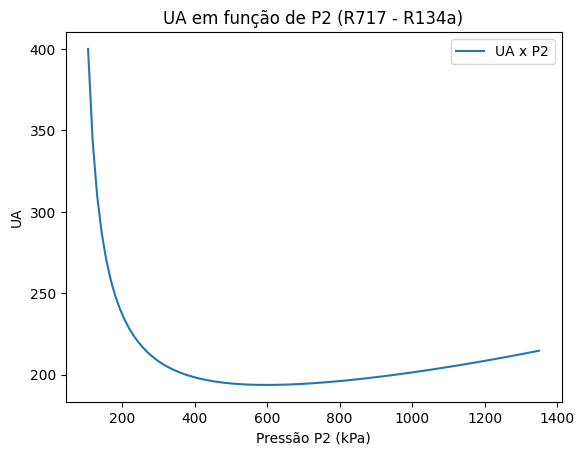

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo superior (50°C)
efi = 0.7
T_evap = -25 + 273.15
superaquecimento = 5

valores_de_P2 = np.linspace(106399, 1350000, 100)
valores_UA = []
pressoes_p2 = []

# Função para calcular COP, UA, e outras variáveis
for P_2 in valores_de_P2:
    # Ponto 1
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)
    af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)
    af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
    s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)
    af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3
    s_4 = CP.PropsSI('S', 'H', h_4,'P', P_1, refri2)
    af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

    # Ponto 5 (antes do trocador intermediário do ciclo superior)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
    s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)
    af5 = (h_5 - h0_1) - (t0 * (s_5 - s0_1))

    # Ponto 6 (depois do trocador intermediário do ciclo superior)
    Temperatura_6 = Temperatura_5 + superaquecimento
    P_6 = P_5
    h_6 = CP.PropsSI('H', 'P', P_6, 'T', Temperatura_6, refri1)
    s_6 = CP.PropsSI('S', 'P', P_6, 'T', Temperatura_6, refri1)
    af6 = (h_6 - h0_1) - (t0 * (s_6 - s0_1))

    # Ponto 8
    P_8 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_8 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
    s_8 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
    af8 = (h_8 - h0_1) - (t0 * (s_8 - s0_1))
    Temperatura_8 = T_cond

    # Ponto 7
    P_7 = P_8
    h_7s = CP.PropsSI('H', 'P', P_7, 'S', s_6, refri1)
    h_7 = ((h_7s - h_6) / efi) + h_6
    s_7 = CP.PropsSI('S', 'P', P_7, 'H', h_7, refri1)
    af7 = (h_7 - h0_1) - (t0 * (s_7 - s0_1))

    # Ponto 9
    P_9 = P_8
    h_9 = h_5 + h_8 - h_6
    s_9 = CP.PropsSI('S', 'P', P_9, 'H', h_9, refri1)
    af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))
    Temperatura_9 = CP.PropsSI('T', 'P', P_9, 'H', h_9, refri1)

    # Ponto 10
    h_10 = h_9
    P_10 = P_5
    Temperatura_10 = CP.PropsSI('T', 'P', P_10, 'H', h_10, refri1)
    s_10 = CP.PropsSI('S', 'P', P_10, 'H', h_10, refri1)
    af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_10 - h_5))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_7 - h_6)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_2 - Temperatura_10) - (Temperatura_3 - Temperatura_5)) / np.log((Temperatura_2 - Temperatura_10) / (Temperatura_3 - Temperatura_5)))

    # Cálculo de Q
    Q = m2 * (h_5 - h_10)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m
    valores_UA.append(UA)
    pressoes_p2.append(P_2 / 1e3)

# Plotar o gráfico COP x Psep
plt.plot(pressoes_p2, valores_UA, label='UA x P2')

# Configurações do gráfico
plt.xlabel('Pressão P2 (kPa)')
plt.ylabel('UA')
plt.title('UA em função de P2 (R717 - R134a)')
plt.legend()
plt.grid(False)
plt.show()

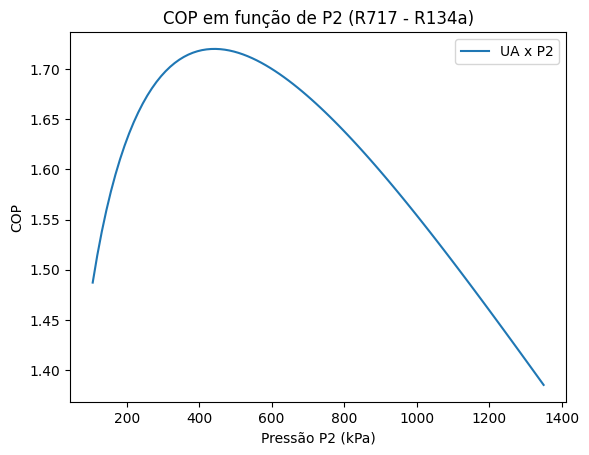

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
superaquecimento = 5  # Superaquecimento fixo em 5 °C
valores_de_P2 = np.linspace(106399, 1350000, 100)

valores_COP = []
pressoes_p2 = []

# Função para calcular COP, UA, e outras variáveis
for P_2 in valores_de_P2:
    # Ponto 1
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (antes do trocador intermediário do ciclo superior)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)

    # Ponto 6 (depois do trocador intermediário do ciclo superior)
    Temperatura_6 = Temperatura_5 + superaquecimento
    P_6 = P_5
    h_6 = CP.PropsSI('H', 'P', P_6, 'T', Temperatura_6, refri1)
    s_6 = CP.PropsSI('S', 'P', P_6, 'T', Temperatura_6, refri1)

    # Ponto 8
    P_8 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_8 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 7
    P_7 = P_8
    h_7s = CP.PropsSI('H', 'P', P_7, 'S', s_6, refri1)
    h_7 = ((h_7s - h_6) / efi) + h_6

    # Ponto 9
    P_9 = P_8
    h_9 = h_5 + h_8 - h_6
    s_9 = CP.PropsSI('S', 'P', P_9, 'H', h_9, refri1)

    # Ponto 10
    h_10 = h_9
    P_10 = P_5

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_10 - h_5))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_7 - h_6)
    COP = carga_termica / (w1 + w2)
    valores_COP.append(COP)
    pressoes_p2.append(P_2 / 1e3)

# Plotar o gráfico COP x Psep
plt.plot(pressoes_p2, valores_COP, label='UA x P2')

# Configurações do gráfico
plt.xlabel('Pressão P2 (kPa)')
plt.ylabel('COP')
plt.title('COP em função de P2 (R717 - R134a)')
plt.legend()
plt.grid(False)
plt.show()